In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.mass_univariate import permuted_ols

In [2]:
#Load Localizer Contrast
n_samples = 94
localizer_dataset = datasets.fetch_localizer_contrasts(['left button press (auditory cue)'], n_subjects=n_samples)

#print basic information on the dataset
print('First constrast nifti image (3D) is located at: %s'% localizer_dataset.cmaps[0]) #cmaps: string list, Paths to constrast maps

tested_var = localizer_dataset.ext_vars['pseudo']
# Quality check / Remove subjects with bad tested variate

mask_quality_check = np.where(tested_var != b'None')[0]
n_samples = mask_quality_check.size
contrast_map_filenames = [localizer_dataset.cmaps[i] for i in mask_quality_check]

tested_var = tested_var[mask_quality_check].astype(float).reshape((-1,1))
print("Actual number of subjects after quality check: %d" %n_samples)




Dataset created in /home/nsy/nilearn_data/brainomics_localizer

Downloaded 23560752 of 23560752 bytes (100.0%,    0.0s remaining) ...done. (42 seconds, 0 min)
Extracting data from /home/nsy/nilearn_data/brainomics_localizer/ba7b27c77d5b70ff713ef5a60b676b4f/brainomics_data_21.zip..... done.
Downloaded 1555 of 1555 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)
Downloaded 64001 of 64001 bytes (100.0%,    0.0s remaining) ...done. (4 seconds, 0 min)
/home/nsy/anaconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:2315: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
First constrast nifti image (3D) is located at: /home/nsy/nilearn_data/brainomics_localizer/brainomics_data/S01/c_map_left_auditory_click.nii.gz
Actual number of subjects after quality check: 89


In [4]:
# Mask Data

nifti_masker = NiftiMasker(smoothing_fwhm=5, memory='nilearn_cache', memory_level=1) #cache options
fmri_masked = nifti_masker.fit_transform(contrast_map_filenames)

/home/nsy/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [5]:
# Anova (parametric F-scores)

from sklearn.feature_selection import f_regression
_, pvals_anova = f_regression(fmri_masked, tested_var, center=True)
pvals_anova *= fmri_masked.shape[1]
pvals_anova[np.isnan(pvals_anova)] = 1
pvals_anova[pvals_anova > 1] = 1
neg_log_pvals_anova = - np.log10(pvals_anova)
neg_log_pvals_anova_unmasked = nifti_masker.inverse_transform(
    neg_log_pvals_anova)

/home/nsy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
# Perform massively univarite analysis with permuted OLS

neg_log_pvals_permuted_ols,_,_ = permuted_ols(
    tested_var, fmri_masked,
    model_intercept=True,
    n_perm = 500, #For the sake of time. Idealy, this should be 10,000
    n_jobs=1) # Can be changed to use more CPUs
neg_log_pvals_permuted_ols_unmasked = nifti_masker.inverse_transform(np.ravel(neg_log_pvals_permuted_ols))

/home/nsy/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


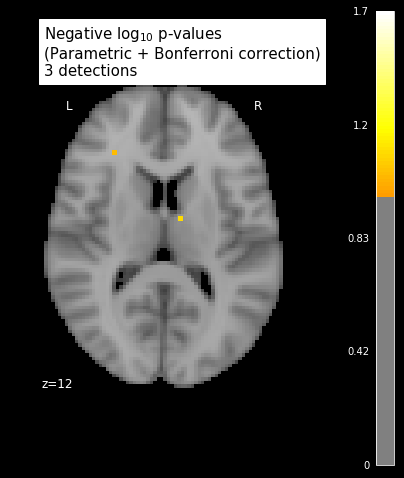

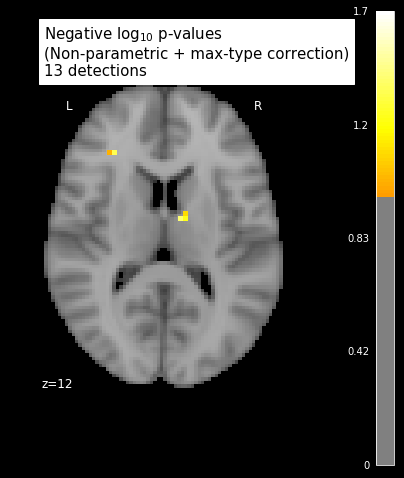

In [8]:
# Visualization
from nilearn.plotting import plot_stat_map, show

# Various plotting parameters
z_slice = 12  # plotted slice

threshold = - np.log10(0.1)  # 10% corrected
vmax = min(np.amax(neg_log_pvals_permuted_ols),
           np.amax(neg_log_pvals_anova))

# Plot Anova p-values
fig = plt.figure(figsize=(5, 7), facecolor='k')

display = plot_stat_map(neg_log_pvals_anova_unmasked,
                        threshold=threshold,
                        display_mode='z', cut_coords=[z_slice],
                        figure=fig, vmax=vmax, black_bg=True)

n_detections = (neg_log_pvals_anova_unmasked.get_data() > threshold).sum()
title = ('Negative $\log_{10}$ p-values'
         '\n(Parametric + Bonferroni correction)'
         '\n%d detections') % n_detections

display.title(title, y=1.2)

# Plot permuted OLS p-values
fig = plt.figure(figsize=(5, 7), facecolor='k')

display = plot_stat_map(neg_log_pvals_permuted_ols_unmasked,
                        threshold=threshold,
                        display_mode='z', cut_coords=[z_slice],
                        figure=fig, vmax=vmax, black_bg=True)

n_detections = (neg_log_pvals_permuted_ols_unmasked.get_data()
                > threshold).sum()
title = ('Negative $\log_{10}$ p-values'
         '\n(Non-parametric + max-type correction)'
         '\n%d detections') % n_detections

display.title(title, y=1.2)

show()
